# Hello everyone!

This is our project for the NLP subject presented by our group: PARS-ing

Team members:

*   Pinar Erbil
*   Angela Remolina
*   Rio Ishibashi
*   Sergio Pardo



## 1. Preliminary analysis:
For this section we will analyze what the dataset contains and how is it structured. We'll also use some cool graphic plots to visualise the content.

First, let's start by loading the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import os

path = 'Colab Notebooks/NLP/Project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()


Mounted at /content/drive


'/content/drive/MyDrive/Colab Notebooks/NLP/Project'

In [6]:
# imports
import re
import pandas as pd
import ast
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Choose whether to use the whole dataset or just a small part of it

In [7]:
dataset = 'cornell-movie-dialogs-small'
# dataset = 'cornell-movie-dialogs'

These are the different files found in the dataset, let's see what's inside of them

In [8]:
with open(f'{dataset}/movie_lines.txt') as f:
    lines = f.readlines()

with open(f'{dataset}/movie_conversations.txt') as f:
    conversations = f.readlines()

with open(f'{dataset}/movie_titles_metadata.txt', encoding='latin-1') as f:
    titles = f.readlines()

with open(f'{dataset}/movie_characters_metadata.txt', encoding='latin-1') as f:
    characters = f.readlines()

The lines and conversation files that are conected with an ID of the line in the conversation.

> According to the dataset documentation these file contains
* 220,579 conversational exchanges between 10,292 pairs of movie characters
* involves 9,035 characters from 617 movies
* in total 304,713 utterances

Also on the titles file we can see

> Movie metadata included:
* genres
* release year
* IMDB rating
* number of IMDB votes
* IMDB rating

And this information for the characters file

> Character metadata included:
* gender (for 3,774 characters)
* position on movie credits (3,321 characters)


For easier visualization, we'll load the Loading them into a pandas dataframe, starting with the lines.


As we saw before, each column of the dataset is splitted by the string `+++$+++` then we'll set that as a parameter for the split function. Also we'll delete the last `\n` symbol from the line

In [9]:
def clean_text(text): # https://github.com/REDFOX1899/Chatbot/blob/master/Chatbot.py
    text = text.lower()
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"she's", "she is", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"how's", "how is", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", "", text)
    return text

In [10]:
# create dataframe with lines
df_lines = pd.DataFrame({'line_text': lines})

# split into columns
df_lines = df_lines['line_text'].str.split(r'\+\+\+\$\+\+\+', expand=True)
df_lines.columns = ['line_ID', 'speaker_ID', 'movie','speaker','text']

# delete new line character and other blank character
df_lines = df_lines.applymap(lambda x: x.rstrip() if isinstance(x, str) else x)
df_lines['text'] = df_lines['text'].str.rstrip('\n')

# Add column clean text
df_lines['clean_text'] = df_lines['text'].apply(lambda x: clean_text(x))

# add column speaker + text
df_lines['line'] = df_lines['speaker'] + ": " + df_lines['text']

df_lines.head(5)

,line_ID,speaker_ID,movie,speaker,text,clean_text,line
0,L1045,u0,m0,BIANCA,They do not!,they do not,BIANCA: They do not!
1,L1044,u2,m0,CAMERON,They do to!,they do to,CAMERON: They do to!
2,L985,u0,m0,BIANCA,I hope so.,i hope so,BIANCA: I hope so.
3,L984,u2,m0,CAMERON,She okay?,she okay,CAMERON: She okay?
4,L925,u0,m0,BIANCA,Let's go.,let's go,BIANCA: Let's go.


Now let's do the same thing with all the other txt files

In [11]:
# create dataframe with conversations
df_conv = pd.DataFrame({'conv': conversations})

# split into columns
df_conv = df_conv['conv'].str.split(r'\+\+\+\$\+\+\+', expand=True)
df_conv.columns = ['speaker1_ID', 'speaker2_ID', 'movie_ID','lines_list']

# delete new line character
df_conv['lines_list'] = df_conv['lines_list'].str.rstrip('\n')

# set lines_list to list type
df_conv['lines_list'] = df_conv['lines_list'].apply(ast.literal_eval)

df_conv.head(5)

,speaker1_ID,speaker2_ID,movie_ID,lines_list
0,u0,u2,m0,"[L194, L195, L196, L197]"
1,u0,u2,m0,"[L198, L199]"
2,u0,u2,m0,"[L200, L201, L202, L203]"
3,u0,u2,m0,"[L204, L205, L206]"
4,u0,u2,m0,"[L207, L208]"


In [12]:
# create dataframe with conversations
df_title = pd.DataFrame({'title': titles})

# split into columns
df_title = df_title['title'].str.split(r'\+\+\+\$\+\+\+', expand=True)
df_title.columns = ['movie_ID','title','year','IMBD_rating','IMBD_votes','genres']

# cast types to what they are
df_title['IMBD_rating'] = df_title['IMBD_rating'].astype(float)
df_title['IMBD_votes'] = df_title['IMBD_votes'].astype(int)
# Clean 'year' column using regex (for cases like ' 1989/I ')
df_title['year'] = df_title['year'].apply(lambda x: re.sub(r'\D', '', x))  # \D significa "no dígito"
df_title['year'] = df_title['year'].astype(int)

# delete new line character
df_title['genres'] = df_title['genres'].str.rstrip('\n')

# set genres_list to list type
df_title['genres'] = df_title['genres'].apply(ast.literal_eval)
df_title.head(5)

,movie_ID,title,year,IMBD_rating,IMBD_votes,genres
0,m0,10 things i hate about you,1999,6.9,62847,"[comedy, romance]"
1,m1,1492: conquest of paradise,1992,6.2,10421,"[adventure, biography, drama, history]"
2,m2,15 minutes,2001,6.1,25854,"[action, crime, drama, thriller]"
3,m3,2001: a space odyssey,1968,8.4,163227,"[adventure, mystery, sci-fi]"
4,m4,48 hrs.,1982,6.9,22289,"[action, comedy, crime, drama, thriller]"


In [13]:
# create dataframe with conversations
df_chars = pd.DataFrame({'characters': characters})

# split into columns
df_chars = df_chars['characters'].str.split(r'\+\+\+\$\+\+\+', expand=True)
df_chars.columns = ['Character_ID','name','movie_ID','movie_title','gender','credits_pos']

# delete new line character
df_chars['credits_pos'] = df_chars['credits_pos'].str.rstrip('\n')
df_chars.head(5)

,Character_ID,name,movie_ID,movie_title,gender,credits_pos
0,u0,BIANCA,m0,10 things i hate about you,f,4
1,u1,BRUCE,m0,10 things i hate about you,?,?
2,u2,CAMERON,m0,10 things i hate about you,m,3
3,u3,CHASTITY,m0,10 things i hate about you,?,?
4,u4,JOEY,m0,10 things i hate about you,m,6


For easier handle of the conversations and lines we'll join them together in one dataframe

In [14]:
# Create a guide index
df_conv['index'] = df_conv.index
# Expand list into all sub item lines
expanded_lines = df_conv.explode('lines_list')
# Reset index of expanded df
expanded_lines.reset_index(drop=True, inplace=True)
# merge the line with line ids
merged_df = pd.merge(
    expanded_lines,
    df_lines,
    left_on='lines_list',
    right_on='line_ID',
    how='inner'
)

# Select relevant columns and group by the guide index
merged_df = merged_df[['speaker1_ID', 'speaker2_ID', 'movie_ID', 'lines_list', 'index', 'line']]
merged_df = merged_df.groupby(['index','speaker1_ID', 'speaker2_ID', 'movie_ID'])['line'].apply(list).reset_index()
merged_df = merged_df.rename(columns={'line': 'dialog'})
dialog_df = merged_df.drop(['index'], axis=1)

dialog_df

,speaker1_ID,speaker2_ID,movie_ID,dialog
0,u0,u2,m0,[ BIANCA: Can we make this quick? Roxanne Ko...
1,u0,u2,m0,[ BIANCA: You're asking me out. That's so cu...
2,u0,u2,m0,"[ BIANCA: No, no, it's my fault -- we didn't ..."
3,u0,u2,m0,"[ CAMERON: Why?, BIANCA: Unsolved mystery. ..."
4,u0,u2,m0,"[ BIANCA: Gosh, if only we could find Kat a b..."
...,...,...,...,...
83092,u9028,u9031,m616,[ COGHILL: Do you think she might be interest...
83093,u9028,u9031,m616,[ COGHILL: Choose your targets men. That's ri...
83094,u9030,u9034,m616,[ VEREKER: Colonel Durnford... William Vereke...
83095,u9030,u9034,m616,"[ DURNFORD: Your orders, Mr Vereker?, VEREKE..."


The last dataset `merged_df` shows the complete dialog between two characters. We could also replace the movie ID for the title as we did it before, but for now it is not necessary to do so.


Let's see what our vocabulary is mainly composed with this wordcloud graph

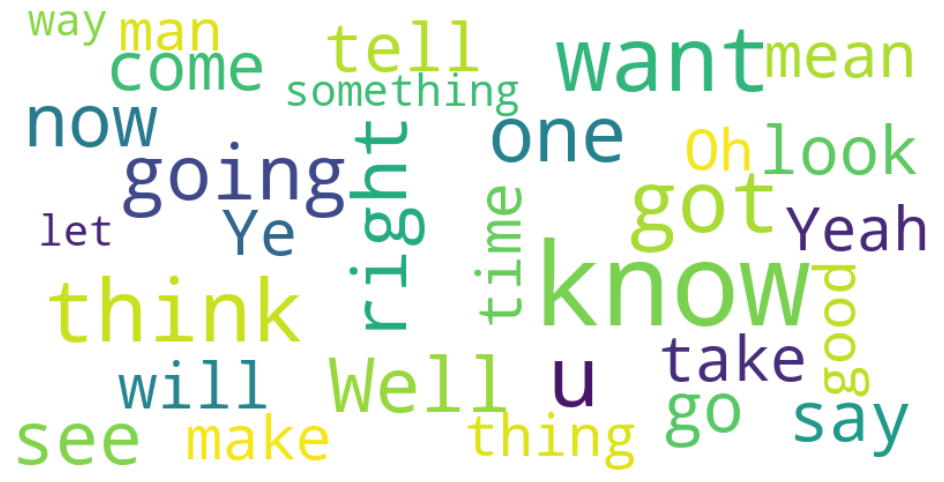

In [ ]:
wordcloud = WordCloud(max_font_size=100, max_words=30, background_color="white",
                          width=800, height=400).generate(' '.join(df_lines['text']))

plt.figure(figsize=(18,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Last graph is still considering stopwords mentioned in the dialogs, let's try to show them without them

In [16]:
lines = df_lines['clean_text']

vec = CountVectorizer(ngram_range=(1,1),stop_words = 'english').fit(lines)
bag_of_words = vec.transform(lines)

sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
common_words = words_freq[:30]

df = pd.DataFrame(common_words, columns = ['LinesText' , 'count'])
df = df.set_index('LinesText')
df

,count
LinesText,
know,21747
just,15693
like,14941
did,14494
got,11482
want,11038
think,10749
right,9969
going,8860


Good, now let's see for the otrher stadistic of the dataset, where we have the movie ratings, genres, years, and others. We can do some cool graphs for those as well, for example let's plot a boxplot to se the IMDB rating by genre

<ipython-input-48-fece6a0f1cc0>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genres', y='IMBD_rating', data=genre_df, palette='Set3')


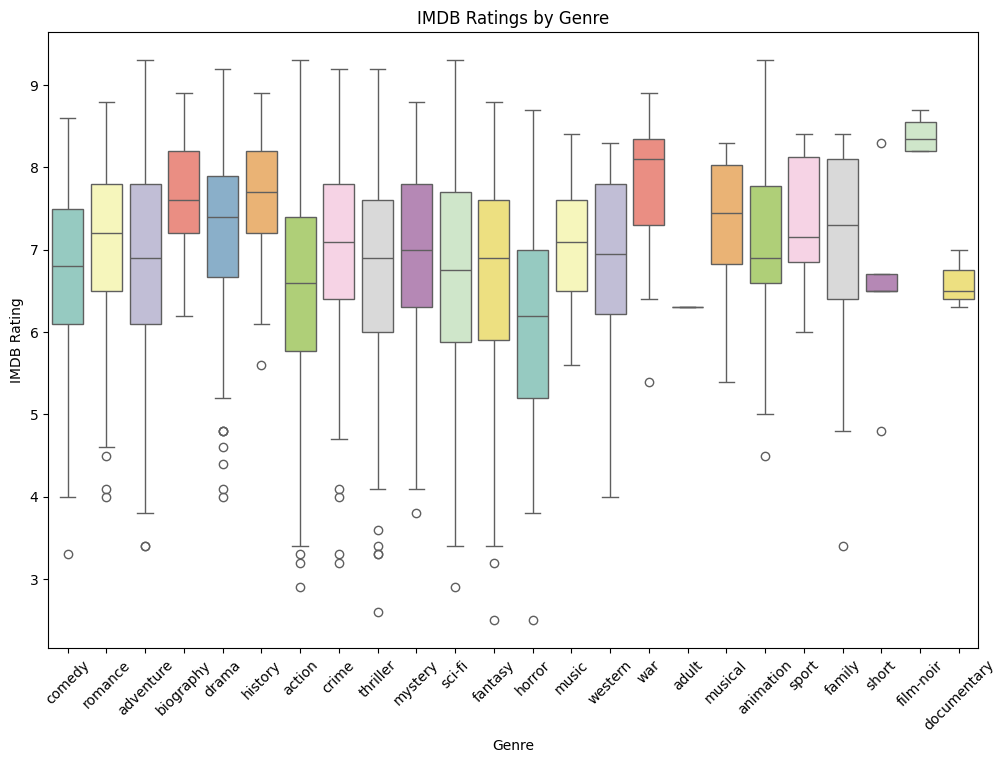

In [ ]:
genre_df = df_title.explode('genres')
genre_df = genre_df.reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.boxplot(x='genres', y='IMBD_rating', data=genre_df, palette='Set3')
plt.xlabel('Genre')
plt.ylabel('IMDB Rating')
plt.title('IMDB Ratings by Genre')
plt.xticks(rotation=45)
plt.show()

That is interesting!
Let's try now a scatter plot of IMDB rating vs. year

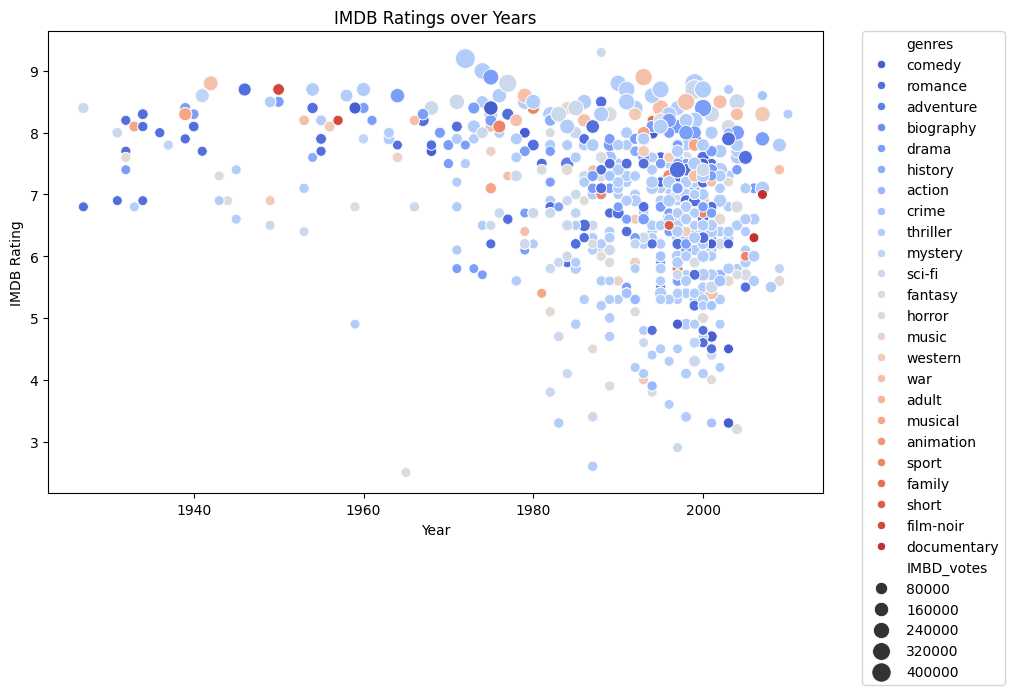

In [ ]:

plt.figure(figsize=(10, 6))
sns.scatterplot(x='year', y='IMBD_rating', data=genre_df, hue='genres', palette='coolwarm', size='IMBD_votes', sizes=(50, 200))
plt.xlabel('Year')
plt.ylabel('IMDB Rating')
plt.title('IMDB Ratings over Years')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

We can see that the distribution of the data tends to the more recent movies. Older movies have less data to work with. But also newermovies are the ones with worst ratings.

### Isolating lines by movie to vectorize

In [ ]:
lines = df_lines['text']
lines

0                                              They do not!
1                                               They do to!
2                                                I hope so.
3                                                 She okay?
4                                                 Let's go.
                                ...                        
304708     Lord Chelmsford seems to want me to stay back...
304709     I'm to take the Sikali with the main column t...
304710                             Your orders, Mr Vereker?
304711     Good ones, yes, Mr Vereker. Gentlemen who can...
304712     Colonel Durnford... William Vereker. I hear y...
Name: text, Length: 304713, dtype: object

### Documents vectorisation

In order to cluster the documents, we need to first convert them into a vector format. We will use the `TfidfVectorizer` from Scikit-Learn to do this.

The `TfidfVectorizer` is very similar to the `CountVectorizer` we used in the text classification tutorial except that it multiplies the term frequency in the document by the inverse document frequecy of the term across the corpus: $\mathrm{tf}(t, d) \cdot \mathrm{idf}(t)$
- here $\mathrm{tf}(t, d)$ is the count of the term $t$ in the document $d$
- idf is inverse document frequency: $\mathrm{idf}(t) = \log{\frac{n + 1}{\mathrm{df}(t) + 1}} + 1$
- $n$ is the number of documents in collection
- and the document frequency, $\mathrm{df}(t)$ is the number of documents that contain the term $t$
- see https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

The use of idf-weighting can be justified in term of information theory:
- the amount of **information** associated with a term quantifies the **amount of surprise** at seeing a term in a document
- the surprise decreases with its (prior) probability of occurrence and information must be additive, so we have:
  - $I(t) = \log{\frac{1}{P(t)}} = -\log{P(t)}$
- the probability of observing a particular term in a document is just the percentage of documents that contain the term:
  - $P(t) = \frac{\mathrm{df}(t)}{n}$
- We smooth this estimate so that small df(t) values don't cause unreasonably high idf values, we have:
  - $P(t) = \frac{\mathrm{df}(t)+1}{n+1}$
  - so $I(t) = \log{\frac{n+1}{\mathrm{df}(t)+1}}$
- The idf value used is then $\mathrm{idf}(t) = I(t) + 1$, where the $+1$ prevents idf from going to zero as df approaches $n$.


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

The vectorisation method takes a number of arguments that control the resulting vocabulary. We have set the following arguments:  
- **max_df = 0.8**: remove words occuring in more than half of the documents (note: this will get rid of any corpus-specific tags)
- **min_df = 5**: remove words occuring in less than 5 documents  
- **stop_words = 'english'**: remove stopwords using an english stopword list

We can now fit the vectorizer to the data:
- Note: we could transform the data at the same time, using the `fit_transform()` method, but we'll wait for now to transform the data

In [ ]:
conversations = dialog_df['dialog']

In [ ]:
conversations[0]

[' BIANCA:  Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.',
 " CAMERON:  Well, I thought we'd start with pronunciation, if that's okay with you.",
 ' BIANCA:  Not the hacking and gagging and spitting part.  Please.',
 " CAMERON:  Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?"]

In [ ]:
vectorizer.fit(lines)

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
vocab = vectorizer.get_feature_names_out()

print(f"Length of vocabulary: {len(vocab)}")

Length of vocabulary: 16663


Wow, that's quite big!

Let's print out a random sample of 100 terms from it to see what they look like:

In [ ]:
import random

sorted(random.sample(vocab.tolist(),100))

['abandon',
 'agree',
 'aliens',
 'amargosa',
 'arousing',
 'arts',
 'atomic',
 'avenue',
 'banished',
 'battle',
 'beethoven',
 'birdy',
 'blake',
 'booger',
 'bren',
 'bump',
 'charade',
 'chaste',
 'civilization',
 'comanche',
 'contract',
 'crandall',
 'custody',
 'dads',
 'declared',
 'defenseless',
 'dell',
 'dictates',
 'duchess',
 'embraced',
 'examined',
 'extreme',
 'farm',
 'fatal',
 'favor',
 'february',
 'geek',
 'helping',
 'hilda',
 'home',
 'interstate',
 'kenya',
 'laughlin',
 'learning',
 'lire',
 'lots',
 'lunar',
 'luncheon',
 'maids',
 'marvelous',
 'mexico',
 'mook',
 'natural',
 'necklace',
 'needles',
 'northeast',
 'notice',
 'organized',
 'outlawed',
 'photographed',
 'photographs',
 'plumbing',
 'pole',
 'pompous',
 'prints',
 'prom',
 'protective',
 'provo',
 'puerto',
 'punishing',
 'reconcile',
 'republican',
 'retirement',
 'reunion',
 'rico',
 'rituals',
 'roadblocks',
 'sacks',
 'sails',
 'seducing',
 'shepherd',
 'sicily',
 'slices',
 'sooner',
 'taste

Most of the terms look pretty good, but the representation looks reasonable.

Now let's vectorize the dataset:

In [ ]:
len(vectorizer.get_feature_names_out())

16663

In [ ]:
vectorizer.get_feature_names_out()[:1000]

array(['00', '000', '007', '0h', '10', '100', '1000', '101', '10th', '11',
       '114', '115', '12', '120', '1200', '125', '13', '134', '13th',
       '14', '140', '15', '150', '15th', '16', '16th', '17', '17th', '18',
       '180', '19', '1922', '1935', '1938', '1939', '1945', '1948',
       '1952', '1953', '1960', '1963', '1967', '1968', '1969', '1970',
       '1971', '1972', '1980', '1984', '1985', '1989', '1992', '1993',
       '1995', '1997', '19th', '1st', '20', '200', '2000', '20th', '21',
       '212', '215', '21st', '22', '23', '237', '23rd', '24', '25', '250',
       '2500', '25th', '26', '27', '28', '29', '2nd', '30', '300', '3000',
       '31', '32', '33', '33rd', '34', '35', '350', '36', '37', '38',
       '39', '3jane', '3rd', '40', '400', '41', '414', '42', '43', '44',
       '45', '450', '46', '47', '48', '4th', '50', '500', '5000', '53',
       '54', '55', '555', '56', '57', '5th', '60', '600', '61', '62',
       '63', '63rd', '64', '65', '66', '68', '69', '70', '700'

In [ ]:
vector_lines = vectorizer.transform(lines)

Here is the sparse vector for the first line:

In [ ]:
print(vector_lines[0])

In [ ]:
df_lines['movie'][0]

' m0'

## Data exploration

Let's play a bit with our data

What if we compute the compute similarity between  documents from the same movie? Let's see:

In [ ]:
for i in range(1,304713):
    if (df_lines['movie'][i] == df_lines['movie'][0]):
      print('Similarity:', vector_lines[0].multiply(vector_lines[i]).sum())


Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similarity: 0.0
Similari

## Clustering

Now we can start applying clustering to our vectorised documents

### Clustering with k-Means

Now that we have computed a vector representation, we can perform the clustering.

There are many different clustering algorithms in common use, from k-Means and Hierarchical clustering to DBScan and Spectral clustering.  
- Many of them are implemented in Scikit-learn: https://scikit-learn.org/stable/modules/clustering.html
- You can easily change the code below to try them out.

We will use the k-Means algorithm since it is very popular, fast, scalable and relatively robust.
- k-Means models the dataset using k circlular clusters
- where each cluster is represented by the centroid of the datapoints it contains.

To apply k-Means we need to decide in advance how many clusters to look for.
- We will set the number of clusters to be exactly the number of categories in the dataset to see if the clustering can recover the original groups from the data.

## Cluster by Movie

In [ ]:
from sklearn.cluster import KMeans

k = 617 ##number of movies

kmeans = KMeans(n_clusters=k, max_iter=10, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_lines)

Initialization complete
Iteration 0, inertia 224998.4929818408.
Iteration 1, inertia 205557.25210584013.
Iteration 2, inertia 200758.0977188421.
Iteration 3, inertia 199436.09211377345.


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


Iteration 4, inertia 198950.22125186608.
Iteration 5, inertia 198701.67287204863.
Iteration 6, inertia 198431.93700994758.
Iteration 7, inertia 198301.67515674286.
Iteration 8, inertia 198217.6800030706.
Iteration 9, inertia 198157.23524273286.
Iteration 10, inertia 198137.54942834718.
Iteration 11, inertia 198098.26350315835.
Iteration 12, inertia 198082.28134186784.
Iteration 13, inertia 198076.1498256222.
Iteration 14, inertia 198073.04392586762.
Iteration 15, inertia 198071.22634409706.
Iteration 16, inertia 198070.1403015293.
Iteration 17, inertia 198069.46888431377.
Iteration 18, inertia 198069.0165454957.


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


Iteration 19, inertia 198068.7410380178.
Iteration 20, inertia 198068.4675661967.
Iteration 21, inertia 198068.18091111362.
Iteration 22, inertia 198067.99229443265.
Iteration 23, inertia 198067.8337596641.
Iteration 24, inertia 198067.67263885378.
Iteration 25, inertia 198067.55299257534.
Iteration 26, inertia 198067.44476456393.
Iteration 27, inertia 198067.35088761064.
Iteration 28, inertia 198067.2242459724.
Iteration 29, inertia 198067.1351439824.
Iteration 30, inertia 198067.0750823026.
Iteration 31, inertia 198067.02409595906.
Iteration 32, inertia 198066.95830990688.


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_common._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/numpy/core/multiarray.py", line 346, in where
    @array_function_from_c_func_and_dispatcher(_multiarray_umath.where)
KeyboardInterrupt: 


Iteration 33, inertia 198066.89356656923.
Iteration 34, inertia 198066.81322819093.
Iteration 35, inertia 198066.75043699887.
Iteration 36, inertia 198066.6817720377.
Iteration 37, inertia 198066.64034767164.
Iteration 38, inertia 198066.6022492458.
Iteration 39, inertia 198066.5489800752.
Iteration 40, inertia 198066.48927537032.
Iteration 41, inertia 198066.4369753654.
Iteration 42, inertia 198066.37699213548.
Iteration 43, inertia 198066.33558869653.
Iteration 44, inertia 198066.31584033766.
Iteration 45, inertia 198066.30062251972.
Iteration 46, inertia 198066.28974524816.
Iteration 47, inertia 198066.28603617614.
Iteration 48, inertia 198066.28100925416.
Iteration 49, inertia 198066.27898630413.
Converged at iteration 49: strict convergence.
Initialization complete
Iteration 0, inertia 224719.6844959207.
Iteration 1, inertia 205050.87303568065.
Iteration 2, inertia 200396.65612720227.
Iteration 3, inertia 199339.17405810519.
Iteration 4, inertia 198857.63401132013.
Iteration 5, in

KMeans(max_iter=100, n_clusters=617, n_init=2, random_state=2307, verbose=True)

The inertia values are actually the *sum of squared distances between each sample to its closest cluster centroid*
- This is the measure that k-Means seeks to minimise
- Note: It is not the cosine distance between document and the cluster center (which is what we would like to minimise), but given that each vector has length one, the squared Euclidean distance is similar to it.  



### Clustering evaluation

Once we have run our clustering algorithm, we can evaluate it

#### Investigating the Clusters

The clustering routine has now produced clusters in a very high dimensional feature space (with tens of thousands of dimansions).
- We can't plot such high dimensional data to see whether the clusters look coherent or not.
- Instead we will need to investigate the coherency of the clusters by looking at the terms occuring in them.

We can see the important terms for each cluster by inspecting the centroid vector for the cluster.
- Let's have a look at the terms with high weights in the centroid of the first cluster:

In [ ]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[vocab[j] for j in sorted_terms[:20]]

['george',
 'know',
 'oh',
 'don',
 'bailey',
 'yes',
 'doing',
 'good',
 'sorry',
 'come',
 'going',
 'like',
 'look',
 'want',
 'hello',
 'mean',
 'gonna',
 'washington',
 'love',
 'business']

In [ ]:
import numpy as np
index = np.argmax([np.dot(centroid,vec) for vec in vector_lines.toarray()])

print(lines[index])

 Do what?!  George-- ?!


We now know what terms were important for defining cluster 0 and have seen a representative document,
- but still don't know how many documents were assigned to to the cluster.
- Let's find out:

In [ ]:
sum(kmeans.labels_ == 0)

294

In [ ]:
for i in range(10):
    print(f"line {i} is in cluster {kmeans.labels_[i]}")

line 0 is in cluster 8
line 1 is in cluster 8
line 2 is in cluster 536
line 3 is in cluster 96
line 4 is in cluster 132
line 5 is in cluster 181
line 6 is in cluster 66
line 7 is in cluster 8
line 8 is in cluster 175
line 9 is in cluster 63


Let's now repeat the process (algorithmically) to get the top terms for all the clusters.
- In the code below, we iterate over the clusters, getting the centroid for each, sort the values and printing out the top terms:

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['george', 'know', 'oh', 'don', 'bailey', 'yes', 'doing', 'good', 'sorry', 'come']
Cluster 1:	['say', 'needed', 'close', 'things', 'maybe', 'said', 'time', 'think', 'filet', 'filiba']
Cluster 2:	['gage', 'folks', 'death', 'crazy', 'start', 'doesn', 'told', 'things', 'night', 'come']
Cluster 3:	['knock', 'don', 'door', 'just', 'come', 'let', 'll', 'want', 'pills', 'hey']
Cluster 4:	['colored', 'hall', 'seeing', 'dog', 'talking', 'thought', 'man', 've', 'got', 'filling']
Cluster 5:	['somebody', 'know', 'like', 'just', 'don', 'got', 'tell', 'maybe', 've', 'kill']
Cluster 6:	['family', 'know', 'got', 'just', 'don', 'going', 'like', 've', 'think', 'come']
Cluster 7:	['motherfucker', 'fuckin', 'kill', 'fuck', 'shit', 'right', 'think', 'got', 'man', 'gonna']
Cluster 8:	['little', 'think', 'yes', 'going', 'kind', 'did', 'll', 'old', 'got', 'yeah']
Cluster 9:	['pretty', 'good', 'sure', 'think', 'look', 'yeah', 'know', 'don', 'looks', 'got']
Cluster 10:	['think'

That's interesting.
- It looks like each of the clusters contains relatively consistent terms.

How many documents have been assigned to each cluster?

In [ ]:
print('Number of lines in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of lines in: 
Cluster 0: 294
Cluster 1: 1
Cluster 2: 1
Cluster 3: 124
Cluster 4: 1
Cluster 5: 451
Cluster 6: 446
Cluster 7: 81
Cluster 8: 78797
Cluster 9: 565
Cluster 10: 1065
Cluster 11: 346
Cluster 12: 2342
Cluster 13: 280
Cluster 14: 62
Cluster 15: 903
Cluster 16: 1186
Cluster 17: 18
Cluster 18: 442
Cluster 19: 749
Cluster 20: 631
Cluster 21: 468
Cluster 22: 406
Cluster 23: 407
Cluster 24: 1201
Cluster 25: 492
Cluster 26: 246
Cluster 27: 1033
Cluster 28: 520
Cluster 29: 573
Cluster 30: 541
Cluster 31: 228
Cluster 32: 649
Cluster 33: 669
Cluster 34: 289
Cluster 35: 1512
Cluster 36: 247
Cluster 37: 128
Cluster 38: 5
Cluster 39: 608
Cluster 40: 1
Cluster 41: 2676
Cluster 42: 1191
Cluster 43: 322
Cluster 44: 111
Cluster 45: 15
Cluster 46: 595
Cluster 47: 390
Cluster 48: 598
Cluster 49: 455
Cluster 50: 243
Cluster 51: 356
Cluster 52: 412
Cluster 53: 745
Cluster 54: 2091
Cluster 55: 658
Cluster 56: 432
Cluster 57: 54
Cluster 58: 121
Cluster 59: 1
Cluster 60: 628
Cluster 61: 873
Clu

## Cluster by Genre


In [ ]:
genres_list = df_title['genres'].apply(pd.Series).stack().unique()

genres_list

array(['comedy', 'romance', 'adventure', 'biography', 'drama', 'history',
       'action', 'crime', 'thriller', 'mystery', 'sci-fi', 'fantasy',
       'horror', 'music', 'western', 'war', 'adult', 'musical',
       'animation', 'sport', 'family', 'short', 'film-noir',
       'documentary'], dtype=object)

In [ ]:
len(genres_list)

24

In [ ]:
from sklearn.cluster import KMeans

k = 24 ##number of genres
kmeans = KMeans(n_clusters=k, max_iter=100, n_init=2, verbose=True, random_state=2307)
kmeans.fit(vector_lines)

Initialization complete
Iteration 0, inertia 274955.14860444295.
Iteration 1, inertia 267420.35525526444.
Iteration 2, inertia 264945.4405502219.
Iteration 3, inertia 264071.25509318063.
Iteration 4, inertia 263805.56089223997.
Iteration 5, inertia 263719.98937553563.
Iteration 6, inertia 263671.61748914444.
Iteration 7, inertia 263654.0214385149.
Iteration 8, inertia 263651.2937021508.
Iteration 9, inertia 263650.3092011083.
Iteration 10, inertia 263649.89431749214.
Iteration 11, inertia 263649.61352628155.
Iteration 12, inertia 263649.5142686948.
Iteration 13, inertia 263649.47571708553.
Iteration 14, inertia 263649.45553983597.
Iteration 15, inertia 263649.44166608655.
Iteration 16, inertia 263649.427623639.
Iteration 17, inertia 263649.40801633603.
Iteration 18, inertia 263649.3895281167.
Iteration 19, inertia 263649.3801905761.
Iteration 20, inertia 263649.3720664845.
Iteration 21, inertia 263649.3673869268.
Iteration 22, inertia 263649.3621036053.
Iteration 23, inertia 263649.361

KMeans(max_iter=100, n_clusters=24, n_init=2, random_state=2307, verbose=True)

In [ ]:
# Get the centroid for the first cluster
centroid = kmeans.cluster_centers_[0]

# Sort terms according to their weights
# (argsort goes from lowest to highest, we reverse the order through slicing)
sorted_terms = centroid.argsort()[::-1]

# Print out the top 10 terms for the cluster
[vocab[j] for j in sorted_terms[:20]]

['dead',
 'know',
 'don',
 'man',
 'thought',
 'want',
 'll',
 'just',
 'people',
 've',
 'think',
 'like',
 'body',
 'alive',
 'isn',
 'mean',
 'killed',
 'guy',
 'mother',
 'right']

In [ ]:
print("Top terms per cluster:")
vocab = vectorizer.get_feature_names_out()

for i in range(kmeans.n_clusters):
    centroid = kmeans.cluster_centers_[i]
    sorted_terms = centroid.argsort()[::-1]
    print(f"Cluster {i}:\t{[vocab[j] for j in sorted_terms[:10]]}")

Top terms per cluster:
Cluster 0:	['dead', 'know', 'don', 'man', 'thought', 'want', 'll', 'just', 'people', 've']
Cluster 1:	['tubbs', 'int', 'apartment', 'rest', 'cut', 'sit', 'shit', 'night', 'look', 'like']
Cluster 2:	['late', 'sorry', 'little', 'don', 'getting', 'night', 'know', 'got', 'running', 'going']
Cluster 3:	['hurry', 'll', 'just', 'come', 'going', 'better', 'let', 'got', 'don', 've']
Cluster 4:	['yes', 'sir', 'oh', 'did', 'course', 'know', 'right', 'thank', 'think', 'll']
Cluster 5:	['good', 'night', 'morning', 'luck', 'idea', 'pretty', 'time', 'll', 'know', 'don']
Cluster 6:	['ll', 'right', 'just', 'going', 'got', 'want', 'think', 've', 'come', 'know']
Cluster 7:	['yeah', 'oh', 'right', 'know', 'sure', 'guess', 'okay', 'll', 'got', 'like']
Cluster 8:	['know', 'don', 'want', 'mean', 'just', 'think', 'll', 'talking', 'going', 'say']
Cluster 9:	['bad', 'news', 'know', 'don', 'good', 'just', 'luck', 'got', 'think', 'feel']
Cluster 10:	['oh', 'god', 'yeah', 'shit', 'right', 'y

In [ ]:
print('Number of lines in: ')

for i in range(kmeans.n_clusters):
    print(f"Cluster {i}: {np.sum(kmeans.labels_ == i)}")

Number of lines in: 
Cluster 0: 1362
Cluster 1: 1
Cluster 2: 653
Cluster 3: 268
Cluster 4: 4027
Cluster 5: 4523
Cluster 6: 233845
Cluster 7: 3583
Cluster 8: 4988
Cluster 9: 1474
Cluster 10: 4395
Cluster 11: 370
Cluster 12: 8896
Cluster 13: 425
Cluster 14: 1875
Cluster 15: 1120
Cluster 16: 4578
Cluster 17: 3733
Cluster 18: 12694
Cluster 19: 3494
Cluster 20: 2259
Cluster 21: 4024
Cluster 22: 1358
Cluster 23: 768


#### Quantitative Evaluation of Clustering Results

Let's now move on to the task of quantitatively evaluating the clustering algorithm. There are two ways to evaluate the results of a clustering algorithm:
- **Intrinsic evaluation** - If the ground truth is not known, you could use:
    - Within-cluster sum-of-squares: that is the *inertia* of the K-Means clustering
    - [Silhouette](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) - "a higher Silhouette Coefficient score relates to a model with better defined clusters"
**Extrinsic evaluation** - If the ground truth is known (as in this case, since we have the categories) we can compute:
    - [Homogeneity](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.homogeneity_score.html#sklearn.metrics.homogeneity_score)
    - [Completeness](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.completeness_score.html#sklearn.metrics.completeness_score)
    - [V-measure](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.v_measure_score.html#sklearn.metrics.v_measure_score)

Let's first have a look at the *intrinsic measures*
- print out within-cluster sum-of-squares and the silhouette coefficient:


There are many possible metrics for clustering evaluation: some can be used when the ground truth labels are known, some can be used when the true labels are unknown.



## **Repeat this with movie**


In [ ]:
from sklearn import metrics

print("Intrinsic evaluation measures:")
print("Within-cluster sum-of-squares:", str(kmeans.inertia_))
print("Silhouette coefficient:", str(metrics.silhouette_score(vector_lines, kmeans.labels_)))

Intrinsic evaluation measures:
Within-cluster sum-of-squares: 263649.3599882329


KeyboardInterrupt: 

The intrinsic evaluation measures are hard to interpret, since their values depend heavily on the difficulty of the clustering task, the amount of data, etc.
- Moreover, the sum-of-squares value will improve monotonically as the number of clusters is increased.

Extrinsic evaluation measures:
- in this case we compare the labels assigned to the documents by the clustering algorithm with the ground truth assignments (newsgroups).
- Since the clusters found could be (i) fewer or more than the number of classes, and (ii) won't be ordered the same as the labels,
- a process of aligning the labels and clusters is performed internally for each of these metrics.

In [ ]:
print('Extrinsic evaluation measures:')
print("Homogeneity:", str(metrics.homogeneity_score(df_title['genres'], kmeans.labels_)))
print("Completeness:", str(metrics.completeness_score(df_title['genres'], kmeans.labels_)))
print("V-measure:", str(metrics.v_measure_score(df_title['genres'], kmeans.labels_)))
print("Adjusted Rand-Index:", str(metrics.adjusted_rand_score(df_title['genres'], kmeans.labels_)))

Extrinsic evaluation measures:


ValueError: You appear to be using a legacy multi-label data representation. Sequence of sequences are no longer supported; use a binary array or sparse matrix instead - the MultiLabelBinarizer transformer can convert to this format.

## Topic Modeling By Movie

In [ ]:
from sklearn.model_selection import train_test_split

documents_train, documents_test, label_train, label_test = train_test_split(lines, df_lines['movie'], test_size=0.4) ##Try not by line but by collections of lines by movies?
print('No. training docs:', len(documents_train))
print('No. testing docs:', len(documents_test))

No. training docs: 182827
No. testing docs: 121886


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english',min_df=5,max_df=.5)
vector_documents_train = vectorizer.fit_transform(documents_train)

In [ ]:
vocab = vectorizer.get_feature_names_out()
len(vocab)

12358

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=30, verbose=1, learning_method='online', max_iter=30)
lda.fit(vector_documents_train)

iteration: 1 of max_iter: 30


KeyboardInterrupt: 

In [ ]:
vector_documents_test = vectorizer.transform(documents_test)
lda.perplexity(vector_documents_test)

In [ ]:
import numpy as np

for i in range(len(lda.components_)):
    sorted_terms = lda.components_[i].argsort()[::-1]
    concatenated_terms = '[' + ', '.join(vocab[i] for i in sorted_terms[:10]) + ']'
    print (f'Topic {i + 1}:\t', concatenated_terms)

In [ ]:
num_words = 10
cols = 5
rows = int(len(lda.components_)/5)

fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows), sharex=True)
axes = axes.flatten()
for topic_idx, topic in enumerate(lda.components_):
    top_terms_index = topic.argsort()[:-num_words - 1:-1]
    top_terms = [vocab[i] for i in top_terms_index]
    weights = topic[top_terms_index]
    ax = axes[topic_idx]
    ax.barh(top_terms, weights, height=0.7)
    ax.set_title(f'Topic {topic_idx +1}',fontdict={'fontsize': 15})
    ax.invert_yaxis()
    ax.set_xscale('log')

plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
plt.tight_layout()
plt.show()

## Indexing
Eventhough our task is not directly related to Information Retrival, we can implement indexing with pyterrier to create a simple dialog answering algorithm.

First lets download the pyterier

In [ ]:
!pip install -q python-terrier

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.6/107.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 335.2/335.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.4/287.4 kB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
  Preparing metadata (setup

Now, we will use the df_lines dataframe. We need docno as a column name, so we will create a new dataframe df_index to apply indexing.

In [ ]:
df_index = df_lines
# line_id is unique so it can be the docno
df_index = df_index.rename(columns={'line_ID': 'docno'})
# We don't need the line and speaker columns so drop them
df_index = df_index.drop(['line', 'speaker'], axis=1)
df_index

,docno,speaker_ID,movie,text
0,L1045,u0,m0,They do not!
1,L1044,u2,m0,They do to!
2,L985,u0,m0,I hope so.
3,L984,u2,m0,She okay?
4,L925,u0,m0,Let's go.
...,...,...,...,...
304708,L666371,u9030,m616,Lord Chelmsford seems to want me to stay back...
304709,L666370,u9034,m616,I'm to take the Sikali with the main column t...
304710,L666369,u9030,m616,"Your orders, Mr Vereker?"
304711,L666257,u9030,m616,"Good ones, yes, Mr Vereker. Gentlemen who can..."


Now the dataframe is ready, we do the indexing.

It takes around 5 minutes for the small dataset

In [ ]:
import pyterrier as pt

if not pt.started():
  pt.init()

# Path to store the indexes
indexer_path = "./index_dialog"
indexer = pt.DFIndexer(indexer_path, overwrite=True, tokeniser="EnglishTokeniser")

# Create the indexing, the metadata is the entire dataframe since we need all of them
index_ref = indexer.index(df_index['text'], df_index)

terrier-assemblies 5.8 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.10.0 has loaded Terrier 5.8 (built by craigm on 2023-11-01 18:05) and terrier-helper 0.0.8



16:35:26.518 [main] WARN org.terrier.structures.indexing.Indexer - Adding an empty document to the index (L1045) - further warnings are suppressed
16:39:14.107 [main] WARN org.terrier.structures.indexing.Indexer - Indexed 18296 empty documents


We can get the statistics of our indexing. We can access the set of terms ie. our vocabulary using `\index.getLexicon()` method. Below we only print the first 500 terms since the vocabulary is quite huge.

In [ ]:
index = pt.IndexFactory.of(index_ref)
print('Statistics:\n------------\n' + index.getCollectionStatistics().toString())

limit = 10
for kv in index.getLexicon():
    print(kv.getKey(),":", kv.getValue().toString())
    limit -= 1
    if limit == 0: break

Statistics:
------------
Number of documents: 304713
Number of terms: 33316
Number of postings: 1341461
Number of fields: 0
Number of tokens: 1406109
Field names: []
Positions:   false

0 : term878 Nt=24 TF=26 maxTF=2147483647 @{0 0 0}
00 : term8172 Nt=35 TF=35 maxTF=2147483647 @{0 78 6}
000 : term1048 Nt=152 TF=171 maxTF=2147483647 @{0 179 2}
007 : term32339 Nt=18 TF=18 maxTF=2147483647 @{0 488 7}
0088 : term28145 Nt=1 TF=1 maxTF=2147483647 @{0 511 7}
01 : term10279 Nt=2 TF=2 maxTF=2147483647 @{0 516 3}
010 : term19426 Nt=1 TF=1 maxTF=2147483647 @{0 524 5}
0100 : term3698 Nt=1 TF=1 maxTF=2147483647 @{0 528 7}
0130 : term19635 Nt=1 TF=1 maxTF=2147483647 @{0 532 1}
015 : term23179 Nt=1 TF=1 maxTF=2147483647 @{0 536 3}


Now, let us define the 3 retrievers we've seen in class and use them for our queries.

1.   **Term Frequency (TF)** $$ TF_{t,d} = \frac{\text{Number of times term t appears in document d}}{\text{Total number of terms in document d}} $$
2.   **Term Frequency-Inverse Document Frequency (TF-IDF)** $$ \text{TF-IDF}_{t,d} = TF_{t,d} \times IDF_t $$ where $IDF_t$ is the **inverse document frequency.**
3.   **BM25** $$BM25_{t,d} = IDF_{t} \times \frac{(k_1 + 1) \times TF_{t,d}}{k_1 \times ((1 - b) + b \times \frac{\text{length of document d}}{\text{average document length}}) + TF_{t,d}}$$


We query a simply input `Hello, how are you feeling today` and print the first 5 results from each retrievers using the rank cut-off operator `%`

In [ ]:
tf = pt.BatchRetrieve(index, wmodel="Tf")
tf_idf = pt.BatchRetrieve(index, wmodel="TF_IDF")
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

query = 'Hello, how are you feeling today'


print("TF:\n", (tf % 5).search(query))
print("TF-IDF:\n", (tf_idf % 5).search(query))
print("BM25:\n", (bm25 % 5).search(query))

TF:
   qid   docid    docno  rank  score                             query
0   1   48205  L295631     0    6.0  Hello, how are you feeling today
1   1   51727  L306991     1    5.0  Hello, how are you feeling today
2   1   18420  L102181     2    4.0  Hello, how are you feeling today
3   1   68208  L370374     3    4.0  Hello, how are you feeling today
4   1  143168  L100700     4    4.0  Hello, how are you feeling today
TF-IDF:
   qid   docid    docno  rank      score                             query
0   1   25926  L180184     0  10.536612  Hello, how are you feeling today
1   1  158409  L138310     1  10.536612  Hello, how are you feeling today
2   1   26181  L180027     2   8.560770  Hello, how are you feeling today
3   1  116371  L646522     3   8.560770  Hello, how are you feeling today
4   1  243623  L460268     4   8.560770  Hello, how are you feeling today
BM25:
   qid   docid    docno  rank      score                             query
0   1   25926  L180184     0  19.265894  

We get similar results with TF-IDF and BM25. BM25 results have the highest scores and TF scores are the lowest. We can say that BM25 performs the best compared to the others.


The results look good but to evaulate the results we need to see the sentences we retrieve! To do that let's create a function called `get_line(line_ID)` which returns the line with the corresponding `line_ID` using the `df_lines`. (We can also use `df_index` with `docno` instead of `line_ID`)

In [ ]:
def get_line(line_ID):
  try:
    return df_lines[df_lines['line_ID'] == line_ID]['text'].values[0]
  except:
    return "Line_ID not found!"

Now, we can use `get_line()` to print the retrieved lines.

In [ ]:
query = 'hello, how are you feeling today'

tf_results = (tf % 5).search(query)[['docno', 'score']]
tf_results["line"] = [get_line(id) for id in tf_results['docno'].tolist()]
print("TF:\n", tf_results)

tfidf_results = (tf_idf % 5).search(query)[['docno', 'score']]
tfidf_results["line"] = [get_line(id) for id in tfidf_results['docno'].tolist()]
print("TF-IDF:\n", tfidf_results)

bm_results = (bm25 % 5).search(query)[['docno', 'score']]
bm_results["line"] = [get_line(id) for id in bm_results['docno'].tolist()]
print("BM25:\n", bm_results)

TF:
      docno  score                                               line
0  L295631    6.0   Yeah.  Yeah. It bothers me a lot.  'Cause, yo...
1  L306991    5.0   I don't have to. That's what the IRS guys do....
2  L102181    4.0   You feel? A soul is what gives you feelings. ...
3  L370374    4.0   Well, we're back to that, huh? I say to you, ...
4  L100700    4.0   You won't be made to feel! Period. You've car...
TF-IDF:
      docno      score                                             line
0  L180184  10.536612                       How are you feeling today?
1  L138310  10.536612                       How are you feeling today?
2  L180027   8.560770      Ah, Mothershead. How are you feeling today?
3  L646522   8.560770          Dunno.  Just have this feeling today...
4  L460268   8.560770   Good morning, Rose. And how do you feel today?
BM25:
      docno      score                                             line
0  L180184  19.265894                       How are you feeling toda

So far so good!  TODO 3


But our taks is the create dialogs and prediction of metadata. Can we implement a dumb dialog generator with only IR? Given a query (line), we can output the **best next dialog line**!

First, we get the results from the  3 retrievers and select the best one (one with the highest score). Then, we can use `df_conv` dataframe the get the next line in the dialog and return it. If the line with the highest score is the last line of a dialog and there is no following line, we get the next highest score until we retrieve a line.

`get_next_line(line_ID)`: Given a `line_id`, gets the dialog and prints the next following line or returns null if no line is following.

In [ ]:
def get_next_line(line_ID):
  # Get all the conversations
  for lines in df_conv['lines_list']:
    if line_ID in lines: # Find the one with our line
      try:
        next_line = lines[lines.index(line_ID)+1]
        return get_line(next_line)
        break
      except:
        return

In [ ]:
#query = 'i believe in america' #m203 = godfather
#query = 'Its too late.  All the contracts have been signed, theyre almost ready to shoot'
#query = 'this ship is unsinkable' #titanic
#query = 'Open the pod bay doors, HAL.' #space odesyee

#query = 'hello, how are you feeling today'

# TODO  5
query = 'hello, how are you feeling today'

tf_results = (tf % 5).search(query)[['docno', 'score']]
tf_results["line"] = [get_line(id) for id in tf_results['docno'].tolist()]

tfidf_results = (tf_idf % 5).search(query)[['docno', 'score']]
tfidf_results["line"] = [get_line(id) for id in tfidf_results['docno'].tolist()]

bm_results = (bm25 % 5).search(query)[['docno', 'score']]
bm_results["line"] = [get_line(id) for id in bm_results['docno'].tolist()]


df_diag = pd.concat([tf_results, tfidf_results, bm_results])
df_diag = df_diag.drop_duplicates(subset=['docno'], keep='first').sort_values(by='score', ascending=False)
diag_list = df_diag['docno'].tolist()

iloc = 0
while True:
  response = get_next_line(diag_list[iloc])
  if response: break
  iloc += 1
print("-", query, "\n-", response)

- hello, how are you feeling today 
-  I feel much better. Thank you for asking. And you?


In [ ]:
#query = 'i believe in america'
#query = 'Its too late.  All the contracts have been signed, theyre almost ready to shoot'
query = 'this ship is unsinkable'
tf_results = (tf % 5).search(query)[['docno', 'score']]
tf_results["line"] = [get_line(id) for id in tf_results['docno'].tolist()]

tfidf_results = (tf_idf % 5).search(query)[['docno', 'score']]
tfidf_results["line"] = [get_line(id) for id in tfidf_results['docno'].tolist()]

bm_results = (bm25 % 5).search(query)[['docno', 'score']]
bm_results["line"] = [get_line(id) for id in bm_results['docno'].tolist()]

df_diag = pd.concat([tf_results, tfidf_results, bm_results])
df_diag = df_diag.drop_duplicates(subset=['docno'], keep='first').sort_values(by='score', ascending=False)
diag_list = df_diag['docno'].tolist()

iloc = 0
while True:
  response = get_next_line(diag_list[iloc])
  if response: break
  iloc += 1
print("-", query, "\n-", response)

- this ship is unsinkable 
-  It is unsinkable. God himself couldn't sink this ship.


# Training a Word2Vec embedding

We install the gensim package that already has an implementation of a Word2Vec embedding


In [2]:
!pip install --upgrade gensim

The Word2Vec embedding only uses sentences as training data, therefore we will use the lines dataframe.

Now we can proceed to do some cleaning of the data:
- remove non-letter characters from each sentence
- lowercase
- tokenize the sentences based on whitespace
- remove any sentence with length less than 2 since it won't be useful for training Word2Vec.

In [17]:
tokenized_sentences = [re.sub('\W', ' ', sentence).lower().split() for sentence in lines]
# remove sentences that are only 1 word  long
tokenized_sentences = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized_sentences[:10]:
    print(sentence)

['they', 'do', 'not']
['they', 'do', 'to']
['i', 'hope', 'so']
['she', 'okay']
['let', 's', 'go']
['okay', 'you', 'are', 'gonna', 'need', 'to', 'learn', 'how', 'to', 'lie']
['i', 'am', 'kidding', 'you', 'know', 'how', 'sometimes', 'you', 'just', 'become', 'this', 'persona', 'and', 'you', 'do', 'not', 'know', 'how', 'to', 'quit']
['like', 'my', 'fear', 'of', 'wearing', 'pastels']
['the', 'real', 'you']
['what', 'good', 'stuff']


Finally we have the data in the right format for training Word2Vec, so we can provide it to the algorithm. For parameters, we set:
- the embedding size to be 30,
- the minimum count for any vocabulary term to be 5
- the size of the context window to 10.

In [18]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(tokenized_sentences, vector_size=30, min_count=5, window=10)

Let's see how big the vocabulary is that Word2Vec ended up using, i.e. how many word vectors did it learn:

In [19]:
len(model.wv)

17466

## Inspecting embeddings and finding similar words

Now that we have a word2vec model trained, what can we do with it?
- Let's print out one of the vectors to see what it looks like:

In [20]:
term = 'car'
model.wv[term]

array([ 0.7896086 , -0.3310924 ,  1.6308185 ,  0.8784001 ,  2.2009351 ,
        0.21919365, -1.9132833 , -0.50967944,  0.22555493, -3.1177356 ,
        1.076253  ,  4.877201  , -0.03517963, -0.04282941, -0.9904555 ,
       -0.8479542 ,  2.251913  ,  0.6702994 ,  0.9315028 , -0.75736374,
       -0.3389257 , -1.634984  , -3.3975523 , -1.4576479 , -2.5147116 ,
        2.21098   , -1.6025856 ,  1.1755892 ,  1.4537675 ,  4.4026604 ],
      dtype=float32)

Unlike LDA's document topic vector, this one has both positive and negative values.

We could now use the model to compute similarities between terms based on their cosine distance in the embedding space.
- Try modifying the terms below to see what their closest neighbouring terms are:
  - Some good terms to try are: hockey, mouse, god, microsoft, clinton, bush, etc.
  - (If yuo see an error, that is because the term you chose is not in the dictionary.)

In [24]:
# term = 'life'
# term = 'escape'
# term ='love'

model.wv.most_similar(term)

[('child', 0.6380418539047241),
 ('pray', 0.6352939605712891),
 ('wish', 0.6054397821426392),
 ('hate', 0.6004620790481567),
 ('mother', 0.5857326984405518),
 ('dear', 0.573095440864563),
 ('choose', 0.572700560092926),
 ('loved', 0.5500016212463379),
 ('wonder', 0.5482140779495239),
 ('hope', 0.5473028421401978)]

## Visualising the embedding vectors using t-SNE

We'll now visualise some of the word vectors in a 3 dimensional space using t-SNE.

The vocabulary of word vectors is quite large (around 25,000). Giving them all to t-SNE will cause it to take far too long to converge.
- So let's first choose a random subset of 500 terms to show:

In [25]:
import random

sample = random.sample(list(model.wv.key_to_index), 500)
print(sample)

['of', 'sauna', 'jason', 'fee', 'bath', 'boom', 'deeper', 'czech', 'lantern', 'gals', '97', 'hitchhiking', 'flatter', 'steed', 'mulwray', 'shaken', 'herr', 'corporal', 'bells', 'harding', 'comparison', 'item', 'delivering', 'overnight', 'fires', 'taxpayers', 'companion', 'oakland', 'both', 'sweaters', 'gazzo', 'midnight', 'shooter', 'condemn', 'driver', 'barge', 'offed', 'cub', 'defensive', 'dynamics', 'symphony', 'capone', 'tens', 'age', 'diagnosis', 'reality', 'bogey', 'certifiable', 'leland', 'bien', 'consultation', 'knight', 'falkstein', 'philosopher', 'dictatorship', 'spirit', 'detail', 'desperation', 'spending', 'capable', 'klingman', 'bob', 'ein', 'frying', 'touchdown', 'culture', 'attraction', 'vegetarian', '1970', 'renault', 'perished', 'surf', 'tuttle', 'farts', 'suitable', 'gig', 'hangar', 'madeleine', 'trio', 'shithead', 'uhh', 'exploit', 'lire', 'goldmouth', 'ceremonies', 'pronto', 'donny', 'weekly', 'return', 'proportion', 'sophia', 'cleaning', 'doctor', 'testa', 'resolve

Now we'll get the word vectors for the sampled terms:

In [26]:
word_vectors = model.wv[sample]
word_vectors

array([[ 2.7987556 , -1.0165359 ,  1.9786754 , ..., -4.0231156 ,
         2.9560094 , -2.633546  ],
       [-0.02395131, -0.12192859,  0.20683023, ...,  0.09707038,
         0.05128655, -0.07023983],
       [-0.26663312, -0.656555  ,  0.23603553, ...,  0.31892025,
         0.4240704 , -0.2650014 ],
       ...,
       [-0.0817215 , -0.6902854 ,  0.13376856, ...,  0.39811414,
         0.01346228, -0.77507675],
       [-0.04686167,  0.00977556,  0.1978235 , ...,  0.28258643,
         0.0057887 , -0.34476355],
       [-0.06977658, -0.735281  ,  0.5195239 , ...,  0.21479493,
         0.09402139, -0.713522  ]], dtype=float32)

And we'll provide the vectors to TSNE to fit a model and transform the data to 3 dimensions:

In [27]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embedding = tsne.fit_transform(word_vectors)

Now transform the data into 3 columns (for x, y, and z):

In [28]:
import numpy as np

x, y, z = np.transpose(tsne_embedding)

And generate the 3d plot:

In [29]:
!pip install plotly

In [30]:
import plotly.express as px

fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

Well that's a not a particularly interesting 3d plot!
- How about we label some of the points on the graph to see what words they correspond to:

In [31]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=sample[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Let's extend the random set of terms with a set of colours to see if they cluster:

In [36]:
# Add some specific terms to sample:
colours = ['red','green','blue','orange','yellow','purple','pink','cream','brown','black','white','gray']

word_vectors = model.wv[colours+sample] #colors+sample

tsne = TSNE(n_components=3)
tsne_embedding = tsne.fit_transform(word_vectors)

x, y, z = np.transpose(tsne_embedding)

In [37]:
import plotly.express as px

r = (-200,200)
fig = px.scatter_3d(x=x, y=y, z=z, range_x=r, range_y=r, range_z=r, text=colours + [None] * 500)
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Note: t-SNE is a stochastic algorithm, so run it a couple of times to see how the visualisation changes.

Have a play around with the visualisation to see whether other sets of terms cluster together.

## Neighbourhood-based analysis


We will also try to visualize the neighbours of the sum of the famous analogy between the king, woman and man:

In [41]:
vec = model.wv.most_similar(model.wv['king'] + (model.wv['woman'] - model.wv['man']))
vec

[('queen', 0.6464802026748657),
 ('child', 0.6387338638305664),
 ('woman', 0.6220283508300781),
 ('princess', 0.5930708050727844),
 ('her', 0.5728397965431213),
 ('beautiful', 0.5500252842903137),
 ('mother', 0.5428062081336975),
 ('beauty', 0.5387280583381653),
 ('birth', 0.5358753204345703),
 ('sister', 0.5309689044952393)]

And we will also try to visualize if there is a relation between the distances of pair of vectors that should be correlated. An example would be man and woman with girl and boy or queen and king. Let's see!

We get the difference between the word 'man' and the word 'woman'. Then we get, for example, the word 'boy' and subtract the previous difference, in the words near to the resulting vector we should find the word 'girl'.

In [44]:
difference = model.wv['man'] - model.wv['woman']
model.wv.most_similar(model.wv['boy']-difference)

[('girl', 0.835101842880249),
 ('woman', 0.7495467662811279),
 ('sister', 0.7370814085006714),
 ('mother', 0.7163063287734985),
 ('dress', 0.6791483163833618),
 ('lady', 0.6717377305030823),
 ('boy', 0.6694137454032898),
 ('she', 0.6566237211227417),
 ('child', 0.6444357633590698),
 ('beautiful', 0.6362797021865845)]

In [45]:
difference = model.wv['man'] - model.wv['woman']
model.wv.most_similar(model.wv['king']-difference)

[('queen', 0.6464802026748657),
 ('child', 0.6387338638305664),
 ('woman', 0.6220283508300781),
 ('princess', 0.5930708050727844),
 ('her', 0.5728397965431213),
 ('beautiful', 0.5500252842903137),
 ('mother', 0.5428062081336975),
 ('beauty', 0.5387280583381653),
 ('birth', 0.5358753204345703),
 ('sister', 0.5309689044952393)]

This way, we are proving 3 things we saw in the theory:
- certain directions in the space have meaning
- semantics is often additive
- analogies are encoded in the embedding

Let's try with another example, in this case we want to see if the neighbours of the word murderer have any relationship with the word itself

In [57]:
model.wv.most_similar(model.wv['murderer'])

[('murderer', 1.0000001192092896),
 ('werewolf', 0.839401125907898),
 ('policeman', 0.8264637589454651),
 ('psychotic', 0.7855367660522461),
 ('prince', 0.7825771570205688),
 ('delusion', 0.7742383480072021),
 ('priest', 0.7706968784332275),
 ('assassin', 0.7703545093536377),
 ('traitor', 0.7652190923690796),
 ('monster', 0.7607550024986267)]

This way, we are able to see that the embedding we've created kind of 'understands' the underlying meaning of the word and in this case it's matched up with words that semantically similar or even synonims like assasin.

Another important characteristic to note is that Word2Vec doesn't work with ngrams. Therefore, it will not be able to process any word that is not in the feature space, for example, confuzzling:

In [60]:
try:
  model.wv.most_similar(model.wv['confuzzling'])
except:
  print('Error: Key not found')

Error: Key not found
